In [2]:
# jupyter 
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))


# initialise
%matplotlib inline

import numpy as np
#import theano
import scipy.io
from keras.utils import np_utils
from matplotlib import pyplot as plt

#from keras.models import Sequential
from keras import layers
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import MaxPooling2D

from keras.layers import Input, concatenate, Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import Input, merge, Conv2D, UpSampling2D
from keras.optimizers import Adam, sgd
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
#from keras import losses
from keras import backend as K
from keras.models import load_model

THEANO_FLAGS='floatX=float32, exception_verbosity=high'


# load data---------------------------------------------------------------
w,h = 28,28

x_load_0 = scipy.io.loadmat('x__10000x28x28.mat')   #dict
y_load_0 = scipy.io.loadmat('y__10000x28x28.mat')

x_load = x_load_0['x_vals2']
y_load = y_load_0['y_vals2']

x_load = np.expand_dims(x_load, 3)
y_load = np.expand_dims(y_load, 3)
print('y_load:', y_load.shape)

#full dataset
x_train = x_load[:-2000] # first 8k out of 10k
y_train = y_load[:-2000]

x_test = x_load[-2000:] # last 2k
y_test = y_load[-2000:]
print('\n')
print('x_train:', x_train.shape)
print('x_test: ', x_test.shape)

#small dataset
x_train = x_load[:800] # first 800 out of 10k
y_train = y_load[:800]

x_test = x_load[800:1000] # next 200
y_test = y_load[800:1000]
print('\nsmaller dataset:\n')
print('x_train:', x_train.shape)
print('x_test: ', x_test.shape)

# adjust type
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_test_20 = x_test[0:20]

Using Theano backend.


('y_load:', (10000L, 28L, 28L, 1L))


('x_train:', (8000L, 28L, 28L, 1L))
('x_test: ', (2000L, 28L, 28L, 1L))

smaller dataset:

('x_train:', (800L, 28L, 28L, 1L))
('x_test: ', (200L, 28L, 28L, 1L))


In [4]:
type(y_train)

numpy.ndarray

In [5]:
#loss
import theano.tensor as T
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def cal_weights_4loss(y_true):
    #size = y_true.shape[1] * y_true.shape[0] #tf syntax
    size = y_true.shape[1] * y_true.shape[2]  #theano syntax
    percentage_back = 0.0
    percentage_fore = 0.0
    percentage_back = np.count_nonzero(y_true == 0)/size*100
    percentage_fore = np.count_nonzero(y_true == 1)/size*100
    weight_back = np.reciprocal(percentage_back)
    weight_fore = np.reciprocal(percentage_fore)
    #print(percentage_back, percentage_fore)
    return percentage_back, percentage_fore


# def weighted_crossentropy_coeff(y_true, y_pred):
# #     y_true = T.transpose(y_true, (0,2,3,1))
# #     y_pred = T.transpose(y_pred, (0,2,3,1))
#     y_true = K.flatten(y_true)
#     y_pred = K.flatten(y_pred)
#     weights = y_true * class_weights[0] 
#     temp = T.eq(y_true, 0)
#     temp = T.cast(temp, 'float32')
#     temp = temp * class_weights[1]
#     weights = weights + temp

#     epsilon = 10e-8
#     y_true = T.clip(y_true, epsilon, 1. - epsilon)
#     coeff = K.sum(((y_true * K.log(y_pred))*weights))
#     return coeff

def weighted_crossentropy_coeff(y_true, y_pred):
#     y_true = T.transpose(y_true, (0,2,3,1))
#     y_pred = T.transpose(y_pred, (0,2,3,1))
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    weights = y_true * class_weights[0] 
    temp = T.eq(y_true, 0)
    temp = T.cast(temp, 'float32')
    temp = temp * class_weights[1]
    weights = weights + temp

    epsilon = 10e-8
    y_true = T.clip(y_true, epsilon, 1. - epsilon)
    #coeff = K.sum(((y_true * K.log(1 - y_pred))*weights))
    coeff = K.sum((((1-y_true) * K.log(y_pred))*weights))
    return coeff


def weighted_crossentropy_loss(y_true, y_pred):
    return -weighted_crossentropy_coeff(y_true, y_pred)


weight_back = np.zeros((y_test.shape[0]))
weight_fore = np.zeros((y_test.shape[0]))

# print(y_test.shape)
# print(weight_back.shape)

for i in np.arange(y_test.shape[0]):
    weight_back[i], weight_fore[i] = cal_weights_4loss(y_test[i])

loss_back = np.mean(weight_back)
loss_fore = np.mean(weight_fore)

ratio = loss_back/loss_fore
    
#class_weights = [1.5, 1.5/ratio]
class_weights = [0.5, 0.5]
print(loss_back, loss_fore, ratio, class_weights)


#----------------------------------


(2396.0, 308.5, 7.766612641815235, [0.5, 0.5])


## processing functions

In [6]:
w, h = 28, 28
inputs = Input((w, h, 1))
net_num = '1'
batch_num = 8
epoch_num = 15
thresh = 0.65
threshon = 0
sample = 0
#thresh = 0.5
loss_type  = 'weihgted'

def train_model(net_num, get_unet0, batch_num, epoch_num, indcoef):

    checkpath = 'checkpoints/unet_' + net_num + '.best.h5'
    modelpath = 'models/unet_' + net_num + '.h5'
    weightpath = 'weights/unet_' + net_num + '.h5'

    model = get_unet0(Input((w,h,1)), indcoef)
    #print(type(model))
    #checkpoint = ModelCheckpoint(checkpath, monitor='val_loss', save_best_only=True)
    
    history = model.fit(x_train, y_train,
          batch_size=batch_num, epochs=epoch_num, 
          verbose=1, shuffle=True,
          validation_split=0.2, 
     #     callbacks=[checkpoint]
         )

    model.save(modelpath)
    model.save_weights(weightpath)
    
    #plot_history(history, indcoef)
    
    return model, history


def compiler_loss(indcoef):

    #if indcoef == 0:
    if indcoef == 'binary':
        #typecoeff = 'acc'
        typecoeff = 'binary_crossentropy'
        valcoeff = 'accuracy'
    
    #if indcoef == 1:
    if indcoef == 'dice':
        typecoeff = 'dice_coef'
        valcoeff = 'val_dice_coef'
        
    #if indcoef == 2:
    if indcoef == 'weighted':
        typecoeff = weighted_crossentropy_loss
        valcoeff = weighted_crossentropy_coeff
        
    return typecoeff, valcoeff

        
def plot_history(history, indcoef):
    
    #if indcoef == 0:
    if indcoef == 'binary':
        typecoeff = 'acc'
        valcoeff = 'val_acc'
    
    #if indcoef == 1:
    if indcoef == 'dice':
        typecoeff = 'dice_coef'
        valcoeff = 'val_dice_coef'
        
    #if indcoef == 2:
    if indcoef == 'weighted':
        typecoeff = 'weighted_crossentropy_coeff'
        valcoeff = 'val_weighted_crossentropy_coeff'
        
#     typecoeff = choose_loss(indcoef)[0]
#     valcoeff = choose_loss(indcoef)[1]
           
    # summarize history for accuracy
    plt.plot(history.history[typecoeff])
    plt.plot(history.history[valcoeff])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    
def predict(model, x_test):
    pred = model.predict(x_test, verbose=1)
    return pred
    
    
def plot_preds0(pred, x_test, sample, thresh, threshon):  
    test = x_test[sample,:,:,:].reshape(w,h)
    
    if threshon == 0:
        thresh = (np.max(test) - np.min(test))/2
    
    print('threshold:', thresh, 'usage:', threshon)
    print('min and max predicted values:',np.min(test), np.max(test))
    plt.imshow(test>thresh, cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Prediction')
    plt.axis('off')
    plt.show()

    plt.imshow(y_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Target')
    plt.axis('off')
    plt.show()

    plt.imshow(x_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Original')
    plt.axis('off')
    plt.show()
    
# def plot_preds(pred, x_test, sample, thresh, threshon):  
#     print(pred.shape)   # (20L, 28L, 28L, 1L)
#     #test = #x_test[sample,:,:,:].reshape(w,h)
#     test = pred[sample,:,:,:]
#     print(test.shape)
#     test2 = test.reshape(w,h)
#     print(test2.shape)

#     if threshon == 0:
#         thresh = (np.max(test) - np.min(test))/2

#     print('threshold:', thresh, 'usage:', threshon)
#     print('min and max predicted values:',np.min(test), np.max(test))
#     #plt.imshow(test2>thresh, cmap=plt.get_cmap('gray'))
#     plt.imshow(test2, cmap=plt.get_cmap('gray'))
#     plt.tight_layout()
#     plt.title('Prediction')
#     plt.axis('off')
#     plt.show()

#     plt.imshow(y_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
#     plt.tight_layout()
#     plt.title('Target')
#     plt.axis('off')
#     plt.show()

#     plt.imshow(x_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
#     plt.tight_layout()
#     plt.title('Original')
#     plt.axis('off')
#     plt.show()
    
    
def plot_preds(pred, x_test, sample, thresh, threshon):  
    print(pred.shape)   # (20L, 28L, 28L, 1L)
    #test = #x_test[sample,:,:,:].reshape(w,h)
    test = pred[sample,:,:,:]
    print(test.shape)
    test2 = test.reshape(w,h)
    print(test2.shape)

#     if threshon == 0:
#         thresh = (np.max(test) - np.min(test))/2

    print('threshold:', thresh, 'usage:', threshon)
    print('min and max predicted values:',np.min(test), np.max(test))
    #plt.imshow(test2>thresh, cmap=plt.get_cmap('gray'))
    if threshon == 0:
        plt.imshow(test2, cmap=plt.get_cmap('gray'))
        title = 'Prediction'
    if threshon == 1:
        plt.imshow(test2>thresh, cmap=plt.get_cmap('gray'))
        title = 'Prediction Thresholded'
    plt.tight_layout()
    plt.title(title)
    plt.axis('off')
    plt.show()

    plt.imshow(y_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Target')
    plt.axis('off')
    plt.show()

    plt.imshow(x_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Original')
    plt.axis('off')
    plt.show()
    
def print_scores():
    num_test = (X_test.shape[0])
    test_score = np.zeros(num_test)

    for i in np.arange(num_test):
        mask = imgs_mask_test[i]
        test_score[i] = np.sum(y_test[i]-mask)
    mean_score = np.mean(test_score)
    print('test scores:', test_score)
    print('mean test score:', mean_score)



In [5]:
def get_unet1v0(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    #conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    
    conv2 = Conv2D(1, (3, 3), activation='linear', padding='same', name='conv6')(conv1)
    
    model = Model(inputs=[inputs], outputs=[conv2])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 0s - loss: 0.4061 - acc: 0.8760 - val_loss: 0.4098 - val_acc: 0.8733
Epoch 2/15
640/640 [==============================] - 0s - loss: 0.4016 - acc: 0.8760 - val_loss: 0.4055 - val_acc: 0.8733
Epoch 3/15
640/640 [==============================] - 0s - loss: 0.3973 - acc: 0.8760 - val_loss: 0.4014 - val_acc: 0.8733
Epoch 4/15
640/640 [==============================] - 0s - loss: 0.3931 - acc: 0.8760 - val_loss: 0.3972 - val_acc: 0.8733
Epoch 5/15
640/640 [==============================] - 0s - loss: 0.3890 - acc: 0.8760 - val_loss: 0.3931 - val_acc: 0.8733
Epoch 6/15
640/640 [==============================] - 0s - loss: 0.3849 - acc: 0.8760 - val_loss: 0.3890 - val_acc: 0.8733
Epoch 7/15
640/640 [==============================] - 0s - loss: 0.3809 - acc: 0.8760 - val_loss: 0.3850 - val_acc: 0.8733
Epoch 8/15
640/640 [==============================] - 0s - loss: 0.3769 - acc: 0.8760 - val_l

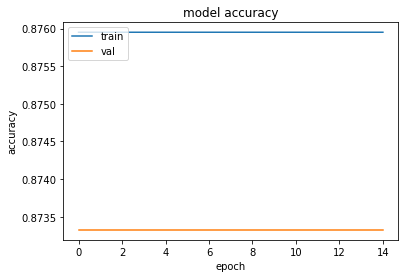

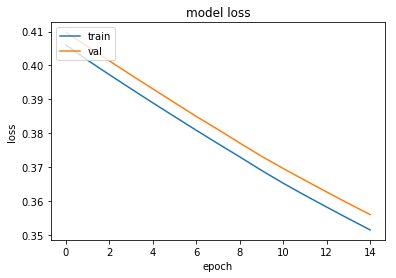

20/20 [==============================] - 0s


In [6]:
loss_type = 'binary'
model_1v0, history_1v0 = train_model('1s', get_unet1v0, 8, 15, loss_type)

plot_history(history_1v0, loss_type)
pred_1v0 = predict(model_1v0, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', -0.027570445, 0.15739508)


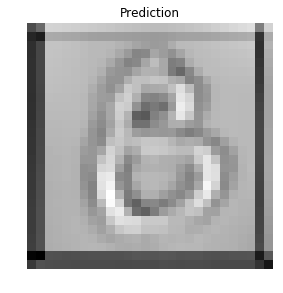

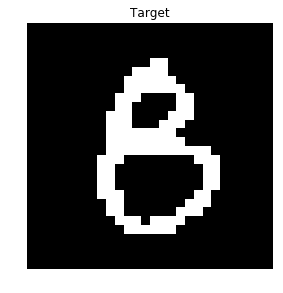

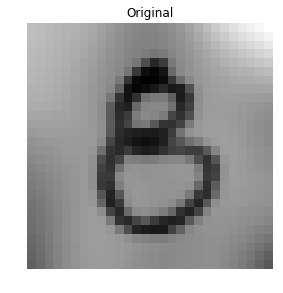

In [16]:
sample = 0
plot_preds(pred_1v0, x_test_20, sample, thresh, 0)

## unet_1s - 1 relu then sigmoid

In [8]:
def get_unet1s(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    #conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    
    conv2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv1)
    
    model = Model(inputs=[inputs], outputs=[conv2])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 0s - loss: 0.6409 - acc: 0.8413 - val_loss: 0.6368 - val_acc: 0.8389
Epoch 2/15
640/640 [==============================] - 0s - loss: 0.6317 - acc: 0.8436 - val_loss: 0.6279 - val_acc: 0.8665
Epoch 3/15
640/640 [==============================] - 0s - loss: 0.6228 - acc: 0.8725 - val_loss: 0.6190 - val_acc: 0.8708
Epoch 4/15
640/640 [==============================] - 0s - loss: 0.6139 - acc: 0.8743 - val_loss: 0.6104 - val_acc: 0.8728
Epoch 5/15
640/640 [==============================] - 0s - loss: 0.6053 - acc: 0.8758 - val_loss: 0.6019 - val_acc: 0.8733
Epoch 6/15
640/640 [==============================] - 0s - loss: 0.5968 - acc: 0.8760 - val_loss: 0.5935 - val_acc: 0.8733
Epoch 7/15
640/640 [==============================] - 0s - loss: 0.5884 - acc: 0.8760 - val_loss: 0.5852 - val_acc: 0.8733
Epoch 8/15
640/640 [==============================] - 0s - loss: 0.5801 - acc: 0.8760 - val_l

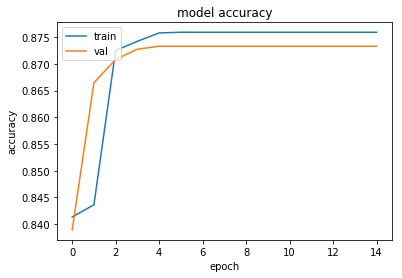

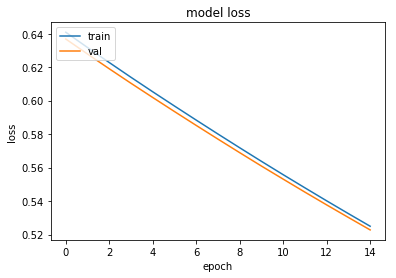

In [9]:
loss_type = 'binary'
model_1s, history = train_model('1s', get_unet1s, 8, 15, loss_type)

plot_history(history, loss_type)

In [10]:
pred = predict(model_1s, x_test_20)
# == pred = model_0.predict(x_test, verbose=1)

20/20 [==============================] - 0s


(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.31560817, 0.46857959)


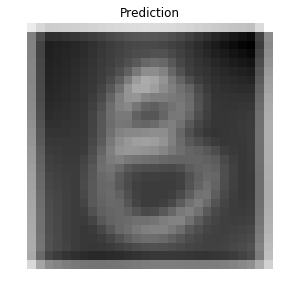

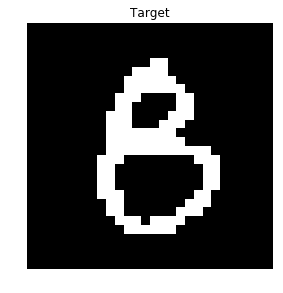

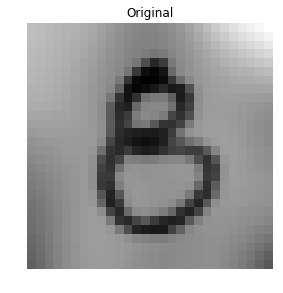

In [11]:
plot_preds(pred, x_test_20, sample, thresh, 0)

## unet_1v2 - 2 relu then sigmoid

In [64]:
def get_unet1v2(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    
    conv2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv1)
    
    model = Model(inputs=[inputs], outputs=[conv2])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 12s - loss: 0.6855 - acc: 0.7762 - val_loss: 0.6809 - val_acc: 0.8301
Epoch 2/15
640/640 [==============================] - 10s - loss: 0.6760 - acc: 0.8403 - val_loss: 0.6708 - val_acc: 0.8392
Epoch 3/15
640/640 [==============================] - 11s - loss: 0.6647 - acc: 0.8425 - val_loss: 0.6590 - val_acc: 0.8402
Epoch 4/15
640/640 [==============================] - 11s - loss: 0.6521 - acc: 0.8433 - val_loss: 0.6441 - val_acc: 0.8418
Epoch 5/15
640/640 [==============================] - 11s - loss: 0.6323 - acc: 0.8668 - val_loss: 0.6215 - val_acc: 0.8721
Epoch 6/15
640/640 [==============================] - 13s - loss: 0.6103 - acc: 0.8747 - val_loss: 0.6005 - val_acc: 0.8721
Epoch 7/15
640/640 [==============================] - 13s - loss: 0.5896 - acc: 0.8747 - val_loss: 0.5804 - val_acc: 0.8722
Epoch 8/15
640/640 [==============================] - 16s - loss: 0.5694 - acc: 0.8756

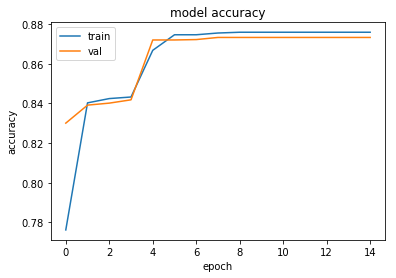

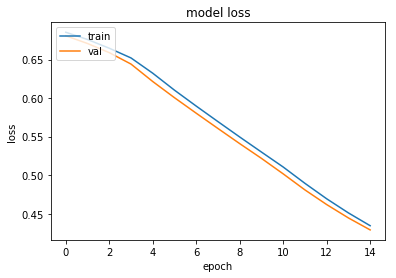

In [19]:
loss_type = 'binary'
model_1v2, history = train_model('1v2', get_unet1v2, 8, 15, loss_type)

plot_history(history, loss_type)

In [22]:
pred = predict(model_1v2, x_test_20)

20/20 [==============================] - 0s


(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.14051643013954163, 'usage:', 0)
('min and max predicted values:', 0.20018397, 0.48121682)


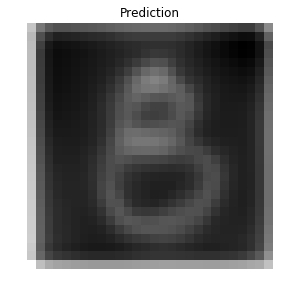

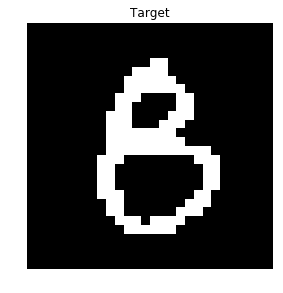

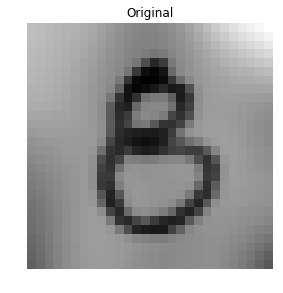

In [23]:
plot_preds(pred, x_test_20, sample, thresh, 0)

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 1s - loss: 0.6758 - acc: 0.8288 - val_loss: 0.6689 - val_acc: 0.8663
Epoch 2/15
640/640 [==============================] - 2s - loss: 0.6609 - acc: 0.8741 - val_loss: 0.6534 - val_acc: 0.8733
Epoch 3/15
640/640 [==============================] - 2s - loss: 0.6454 - acc: 0.8760 - val_loss: 0.6381 - val_acc: 0.8733
Epoch 4/15
640/640 [==============================] - 2s - loss: 0.6297 - acc: 0.8760 - val_loss: 0.6223 - val_acc: 0.8733
Epoch 5/15
640/640 [==============================] - 2s - loss: 0.6134 - acc: 0.8760 - val_loss: 0.6055 - val_acc: 0.8733
Epoch 6/15
640/640 [==============================] - 2s - loss: 0.5960 - acc: 0.8760 - val_loss: 0.5878 - val_acc: 0.8733
Epoch 7/15
640/640 [==============================] - 1s - loss: 0.5771 - acc: 0.8760 - val_loss: 0.5682 - val_acc: 0.8733
Epoch 8/15
640/640 [==============================] - 2s - loss: 0.5565 - acc: 0.8760 - val_l

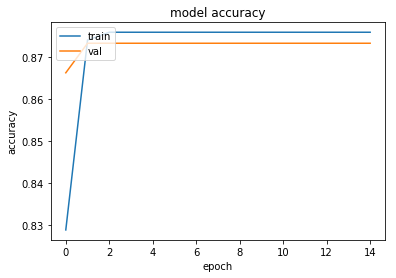

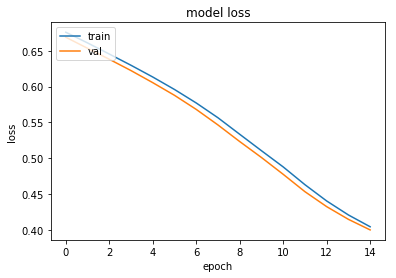

20/20 [==============================] - 0s


In [66]:
loss_type = 'binary'
model_1v2, history = train_model('1v2', get_unet1v2, 8, 15, loss_type)

plot_history(history, loss_type)
pred = predict(model_1v2, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.15281074, 0.45256186)


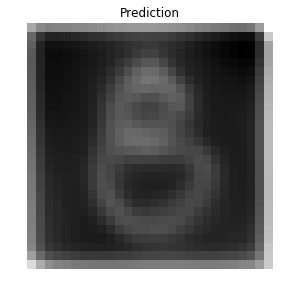

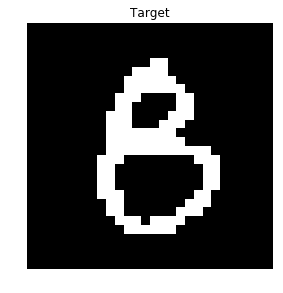

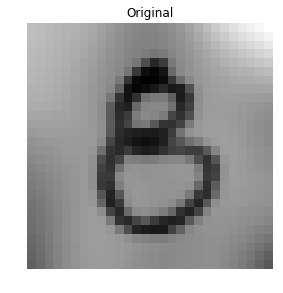

In [67]:
plot_preds(pred, x_test_20, sample, thresh, 0)

In [7]:
def get_unet1v2_2(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    
    conv2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv1)
    conv2 = BatchNormalization(axis=-1)(conv2)
    
    conv3 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv2)
    
    model = Model(inputs=[inputs], outputs=[conv2])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 1s - loss: 0.6604 - acc: 0.8342 - val_loss: 0.4792 - val_acc: 0.8733
Epoch 2/30
640/640 [==============================] - 1s - loss: 0.6151 - acc: 0.8353 - val_loss: 0.3991 - val_acc: 0.8733
Epoch 3/30
640/640 [==============================] - 1s - loss: 0.5635 - acc: 0.8364 - val_loss: 0.3662 - val_acc: 0.8733
Epoch 4/30
640/640 [==============================] - 1s - loss: 0.5180 - acc: 0.8370 - val_loss: 0.3536 - val_acc: 0.8733
Epoch 5/30
640/640 [==============================] - 1s - loss: 0.4551 - acc: 0.8380 - val_loss: 0.3446 - val_acc: 0.8733
Epoch 6/30
640/640 [==============================] - 1s - loss: 0.3905 - acc: 0.8391 - val_loss: 0.3333 - val_acc: 0.8733
Epoch 7/30
640/640 [==============================] - 1s - loss: 0.3593 - acc: 0.8398 - val_loss: 0.3267 - val_acc: 0.8733
Epoch 8/30
640/640 [==============================] - 1s - loss: 0.3378 - acc: 0.8402 - val_l

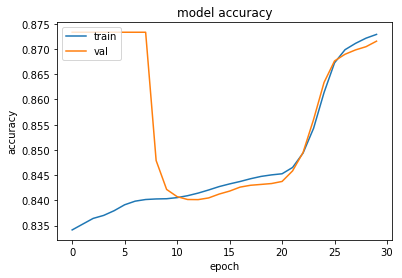

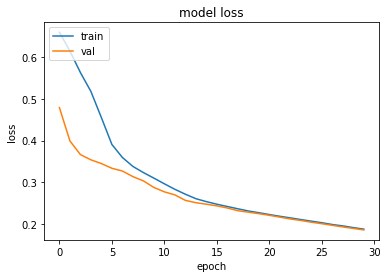

20/20 [==============================] - 0s


In [11]:
loss_type = 'binary'
model_1v2_2, history = train_model('1v2_2', get_unet1v2_2, 8, 30, loss_type)

plot_history(history, loss_type)
pred_1v2_2 = predict(model_1v2_2, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', -0.83775049, 0.61697102)


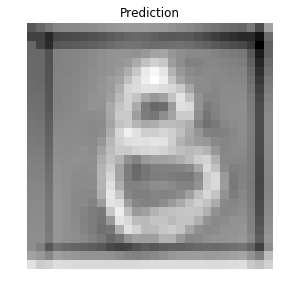

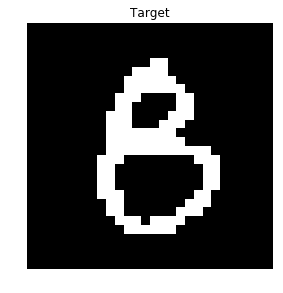

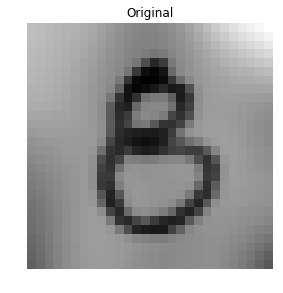

In [12]:
sample = 0
plot_preds(pred_1v2_2, x_test_20, sample, thresh, 0) # 30e

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', -0.51988423, 0.61673188)


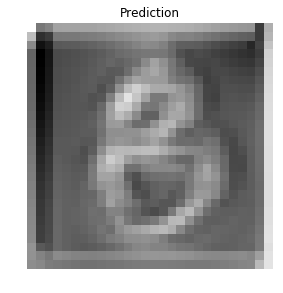

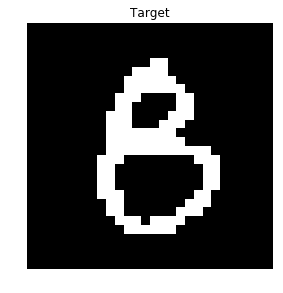

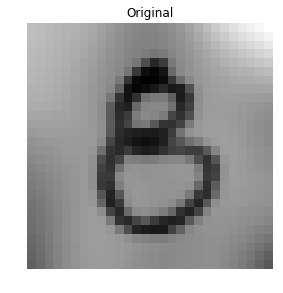

In [10]:
sample = 0
plot_preds(pred, x_test_20, sample, thresh, 0) # 15e

## unet_1v3 - 2 relu with pooling, then sigmoid --- possible mistakes

In [55]:
def get_unet1v3(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    
    conv3 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv1)
    
    model = Model(inputs=[inputs], outputs=[conv3])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


In [58]:
def get_unet1v3(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    
    conv3 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv1)
    
    model = Model(inputs=[inputs], outputs=[conv3])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 0s - loss: 0.6787 - acc: 0.8014 - val_loss: 0.6733 - val_acc: 0.8069
Epoch 2/15
640/640 [==============================] - 0s - loss: 0.6678 - acc: 0.8095 - val_loss: 0.6626 - val_acc: 0.8062
Epoch 3/15
640/640 [==============================] - 0s - loss: 0.6572 - acc: 0.8115 - val_loss: 0.6522 - val_acc: 0.8252
Epoch 4/15
640/640 [==============================] - 0s - loss: 0.6467 - acc: 0.8573 - val_loss: 0.6419 - val_acc: 0.8716
Epoch 5/15
640/640 [==============================] - 0s - loss: 0.6364 - acc: 0.8748 - val_loss: 0.6318 - val_acc: 0.8726
Epoch 6/15
640/640 [==============================] - 0s - loss: 0.6262 - acc: 0.8755 - val_loss: 0.6218 - val_acc: 0.8733
Epoch 7/15
640/640 [==============================] - 0s - loss: 0.6162 - acc: 0.8760 - val_loss: 0.6118 - val_acc: 0.8733
Epoch 8/15
640/640 [==============================] - 0s - loss: 0.6062 - acc: 0.8760 - val_l

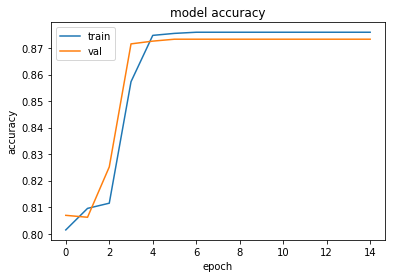

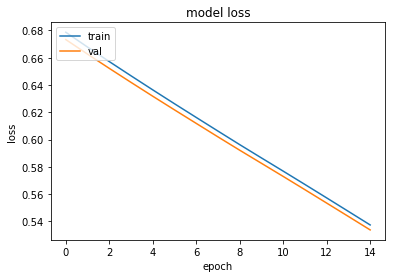

In [25]:
loss_type = 'binary'
model_1v3, history_1v3 = train_model('1v3', get_unet1v3, 8, 15, loss_type)

plot_history(history_1v3, loss_type)

In [26]:
pred_1v3 = predict(model_1v3, x_test_20)

20/20 [==============================] - 0s


(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.33653402, 0.47346696)


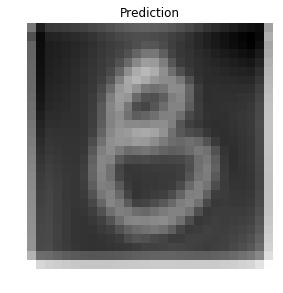

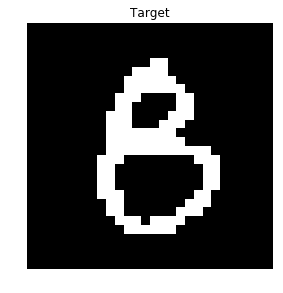

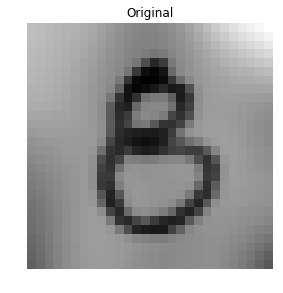

In [60]:
sample = 0
plot_preds(pred_1v3, x_test_20, sample, thresh, 0)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.402, 'usage:', 1)
('min and max predicted values:', 0.36458483, 0.48370075)


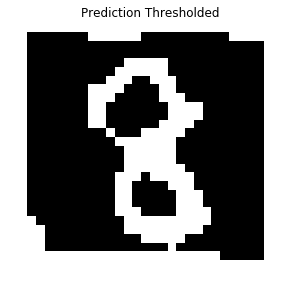

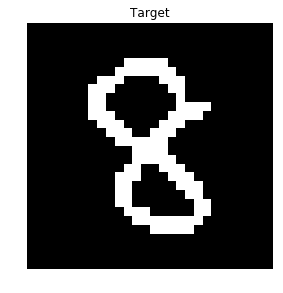

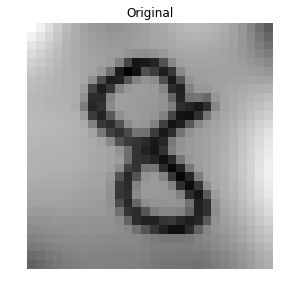

In [34]:
thresh = 0.402
sample = 6
plot_preds(pred_1v3, x_test_20, sample, thresh, 1)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.432, 'usage:', 1)
('min and max predicted values:', 0.40096191, 0.47883576)


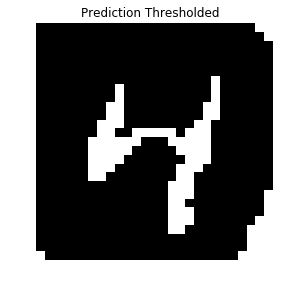

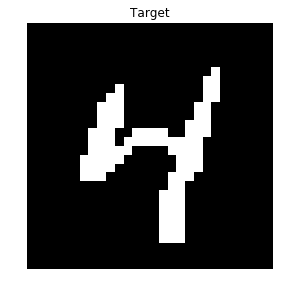

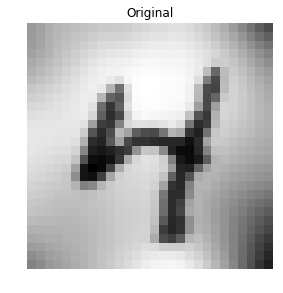

In [66]:
thresh = 0.432
sample = 2
plot_preds(pred_1v3, x_test_20, sample, thresh, 1)

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 1s - loss: 0.6711 - acc: 0.7765 - val_loss: 0.6679 - val_acc: 0.7738
Epoch 2/15
640/640 [==============================] - 1s - loss: 0.6645 - acc: 0.7947 - val_loss: 0.6615 - val_acc: 0.8059
Epoch 3/15
640/640 [==============================] - 1s - loss: 0.6580 - acc: 0.8210 - val_loss: 0.6550 - val_acc: 0.8349
Epoch 4/15
640/640 [==============================] - 1s - loss: 0.6514 - acc: 0.8394 - val_loss: 0.6485 - val_acc: 0.8375
Epoch 5/15
640/640 [==============================] - 1s - loss: 0.6448 - acc: 0.8402 - val_loss: 0.6417 - val_acc: 0.8377
Epoch 6/15
640/640 [==============================] - 1s - loss: 0.6379 - acc: 0.8416 - val_loss: 0.6348 - val_acc: 0.8402
Epoch 7/15
640/640 [==============================] - 1s - loss: 0.6308 - acc: 0.8428 - val_loss: 0.6278 - val_acc: 0.8402
Epoch 8/15
640/640 [==============================] - 1s - loss: 0.6237 - acc: 0.8428 - val_l

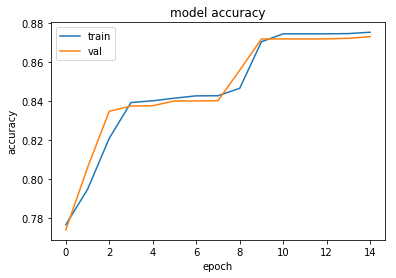

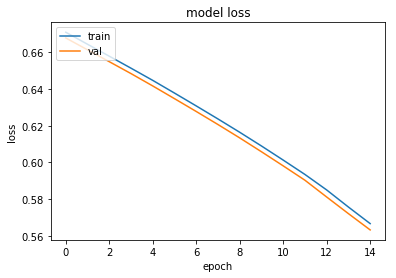

In [23]:
loss_type = 'binary'
model_1v3, history_1v3 = train_model('1v3', get_unet1v3, 8, 15, loss_type)

plot_history(history_1v3, loss_type)

In [24]:
pred_1v3 = predict(model_1v3, x_test_20)

20/20 [==============================] - 0s


(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.13, 'usage:', 0)
('min and max predicted values:', 0.35273835, 0.4994618)


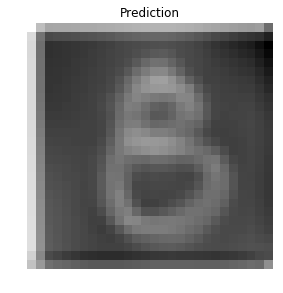

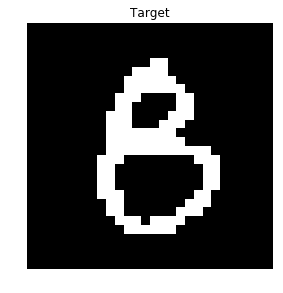

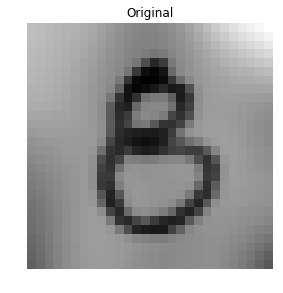

In [25]:
sample = 0
plot_preds(pred_1v3, x_test_20, sample, thresh, 0)

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 0s - loss: 0.7584 - acc: 0.1540 - val_loss: 0.7529 - val_acc: 0.1592
Epoch 2/15
640/640 [==============================] - 0s - loss: 0.7485 - acc: 0.1586 - val_loss: 0.7432 - val_acc: 0.1644
Epoch 3/15
640/640 [==============================] - 0s - loss: 0.7388 - acc: 0.1801 - val_loss: 0.7336 - val_acc: 0.1929
Epoch 4/15
640/640 [==============================] - 0s - loss: 0.7291 - acc: 0.1902 - val_loss: 0.7240 - val_acc: 0.1923
Epoch 5/15
640/640 [==============================] - 0s - loss: 0.7195 - acc: 0.1879 - val_loss: 0.7145 - val_acc: 0.1848
Epoch 6/15
640/640 [==============================] - 0s - loss: 0.7098 - acc: 0.1828 - val_loss: 0.7047 - val_acc: 0.1929
Epoch 7/15
640/640 [==============================] - 0s - loss: 0.6991 - acc: 0.2417 - val_loss: 0.6933 - val_acc: 0.5165
Epoch 8/15
640/640 [==============================] - 0s - loss: 0.6877 - acc: 0.7130 - val_l

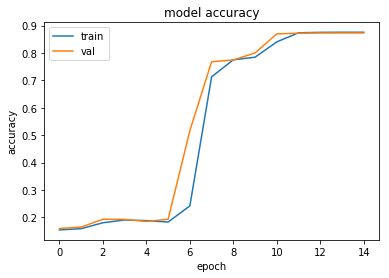

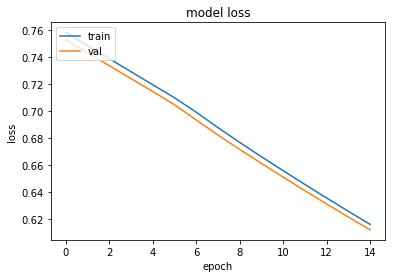

20/20 [==============================] - 0s


In [65]:
loss_type = 'binary'
model_1v3, history_1v3 = train_model('1v3', get_unet1v3, 8, 15, loss_type)

plot_history(history_1v3, loss_type)
pred_1v3 = predict(model_1v3, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.41940168, 0.48537645)


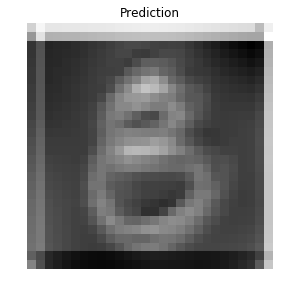

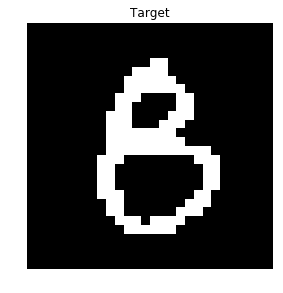

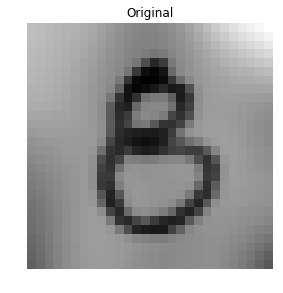

In [66]:
sample = 0
plot_preds(pred_1v3, x_test_20, sample, thresh, 0)

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 1s - loss: 0.6656 - acc: 0.8747 - val_loss: 0.6612 - val_acc: 0.8721
Epoch 2/15
640/640 [==============================] - 1s - loss: 0.6564 - acc: 0.8747 - val_loss: 0.6521 - val_acc: 0.8721
Epoch 3/15
640/640 [==============================] - 1s - loss: 0.6473 - acc: 0.8748 - val_loss: 0.6432 - val_acc: 0.8725
Epoch 4/15
640/640 [==============================] - 1s - loss: 0.6383 - acc: 0.8754 - val_loss: 0.6342 - val_acc: 0.8732
Epoch 5/15
640/640 [==============================] - 1s - loss: 0.6291 - acc: 0.8759 - val_loss: 0.6248 - val_acc: 0.8733
Epoch 6/15
640/640 [==============================] - 1s - loss: 0.6193 - acc: 0.8760 - val_loss: 0.6151 - val_acc: 0.8733
Epoch 7/15
640/640 [==============================] - 1s - loss: 0.6095 - acc: 0.8760 - val_loss: 0.6051 - val_acc: 0.8733
Epoch 8/15
640/640 [==============================] - 1s - loss: 0.5989 - acc: 0.8760 - val_l

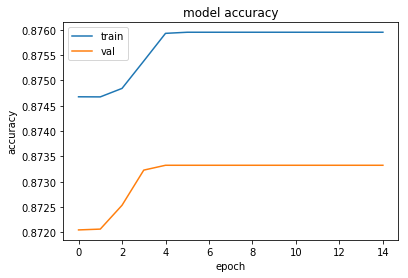

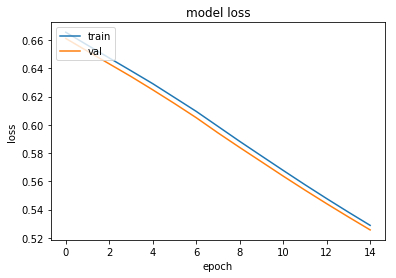

20/20 [==============================] - 0s


In [59]:
loss_type = 'binary'
model_1v3, history_1v3 = train_model('1v3', get_unet1v3, 8, 15, loss_type)

plot_history(history_1v3, loss_type)
pred_1v3 = predict(model_1v3, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.32301655, 0.46112978)


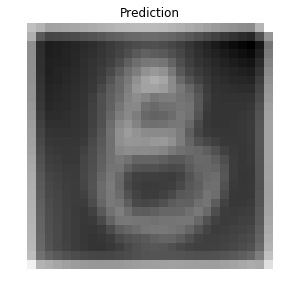

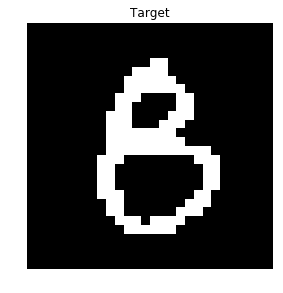

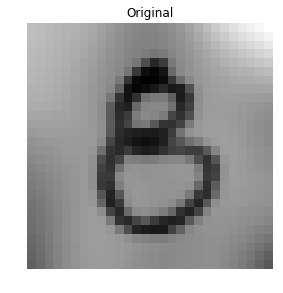

In [60]:
sample = 0
plot_preds(pred_1v3, x_test_20, sample, thresh, 0)

Train on 640 samples, validate on 160 samples
Epoch 1/40
640/640 [==============================] - 1s - loss: 0.6999 - acc: 0.2589 - val_loss: 0.6973 - val_acc: 0.2777
Epoch 2/40
640/640 [==============================] - 1s - loss: 0.6949 - acc: 0.3102 - val_loss: 0.6922 - val_acc: 0.3605
Epoch 3/40
640/640 [==============================] - 1s - loss: 0.6894 - acc: 0.4281 - val_loss: 0.6865 - val_acc: 0.5959
Epoch 4/40
640/640 [==============================] - 1s - loss: 0.6836 - acc: 0.8122 - val_loss: 0.6808 - val_acc: 0.8773
Epoch 5/40
640/640 [==============================] - 1s - loss: 0.6776 - acc: 0.8762 - val_loss: 0.6745 - val_acc: 0.8705
Epoch 6/40
640/640 [==============================] - 1s - loss: 0.6711 - acc: 0.8657 - val_loss: 0.6676 - val_acc: 0.8568
Epoch 7/40
640/640 [==============================] - 1s - loss: 0.6634 - acc: 0.8660 - val_loss: 0.6597 - val_acc: 0.8770
Epoch 8/40
640/640 [==============================] - 1s - loss: 0.6555 - acc: 0.8776 - val_l

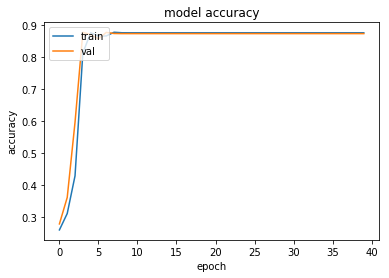

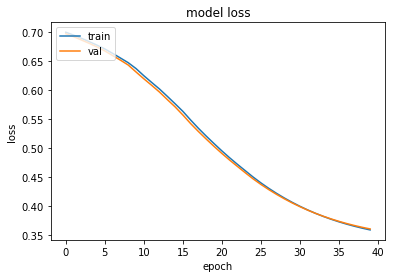

In [62]:
loss_type = 'binary'
model_1v3, history_1v3 = train_model('1v3', get_unet1v3, 8, 40, loss_type)

plot_history(history_1v3, loss_type)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.32301655, 0.46112978)


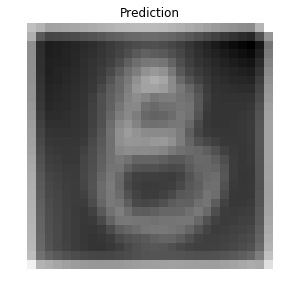

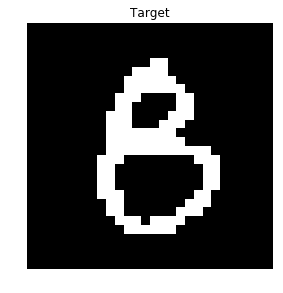

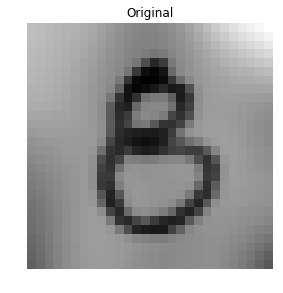

In [63]:
#pred_1v3 = predict(model_1v3, x_test_20)
sample = 0
plot_preds(pred_1v3, x_test_20, sample, thresh, 0)

## unet_1v4 - unet_1v3 with correct layer connections

In [68]:
def get_unet1v4(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    
    conv3 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv2)
    
    model = Model(inputs=[inputs], outputs=[conv3])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 8s - loss: 0.7051 - acc: 0.1832 - val_loss: 0.6942 - val_acc: 0.5123
Epoch 2/15
640/640 [==============================] - 7s - loss: 0.6847 - acc: 0.7786 - val_loss: 0.6755 - val_acc: 0.8670
Epoch 3/15
640/640 [==============================] - 8s - loss: 0.6633 - acc: 0.8743 - val_loss: 0.6508 - val_acc: 0.8733
Epoch 4/15
640/640 [==============================] - 9s - loss: 0.6350 - acc: 0.8760 - val_loss: 0.6197 - val_acc: 0.8733
Epoch 5/15
640/640 [==============================] - 7s - loss: 0.6032 - acc: 0.8760 - val_loss: 0.5870 - val_acc: 0.8733
Epoch 6/15
640/640 [==============================] - 7s - loss: 0.5682 - acc: 0.8760 - val_loss: 0.5510 - val_acc: 0.8733
Epoch 7/15
640/640 [==============================] - 8s - loss: 0.5308 - acc: 0.8760 - val_loss: 0.5139 - val_acc: 0.8733
Epoch 8/15
640/640 [==============================] - 8s - loss: 0.4951 - acc: 0.8760 - val_l

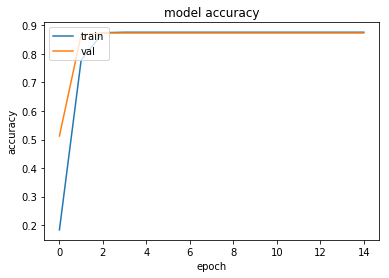

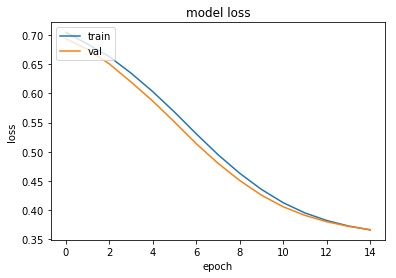

In [69]:
loss_type = 'binary'
model_1v4, history_1v4 = train_model('1v4', get_unet1v4, 8, 15, loss_type)

plot_history(history_1v4, loss_type)

In [70]:
pred_1v4 = predict(model_1v4, x_test_20)

20/20 [==============================] - 0s


(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.432, 'usage:', 0)
('min and max predicted values:', 0.08500196, 0.41675612)


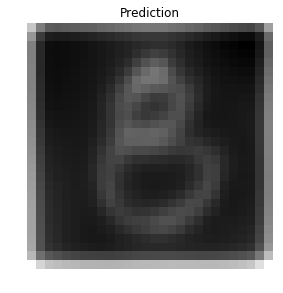

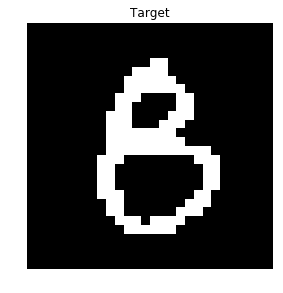

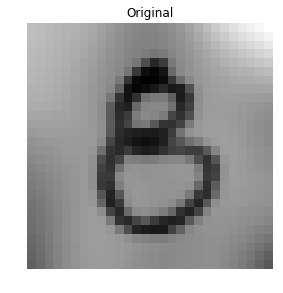

In [71]:
sample = 0
plot_preds(pred_1v4, x_test_20, sample, thresh, 0)

## unet_1v5 - extra sigmoid layer from 1v4

In [74]:
def get_unet1v5(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv3 = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(conv2)
    conv4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv3)
    
    model = Model(inputs=[inputs], outputs=[conv4])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 30s - loss: 0.4471 - acc: 0.8747 - val_loss: 0.4402 - val_acc: 0.8721
Epoch 2/15
640/640 [==============================] - 29s - loss: 0.4291 - acc: 0.8747 - val_loss: 0.4246 - val_acc: 0.8721
Epoch 3/15
640/640 [==============================] - 32s - loss: 0.4147 - acc: 0.8747 - val_loss: 0.4123 - val_acc: 0.8725
Epoch 4/15
640/640 [==============================] - 37s - loss: 0.4034 - acc: 0.8758 - val_loss: 0.4027 - val_acc: 0.8733
Epoch 5/15
640/640 [==============================] - 47s - loss: 0.3950 - acc: 0.8760 - val_loss: 0.3959 - val_acc: 0.8733
Epoch 6/15
640/640 [==============================] - 26s - loss: 0.3894 - acc: 0.8760 - val_loss: 0.3920 - val_acc: 0.8733
Epoch 7/15
640/640 [==============================] - 32s - loss: 0.3861 - acc: 0.8760 - val_loss: 0.3895 - val_acc: 0.8733
Epoch 8/15
640/640 [==============================] - 27s - loss: 0.3837 - acc: 0.8760

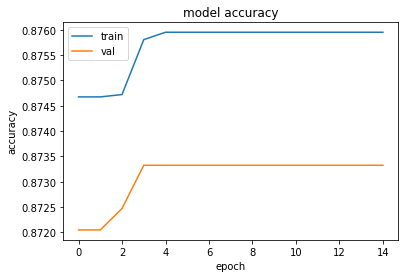

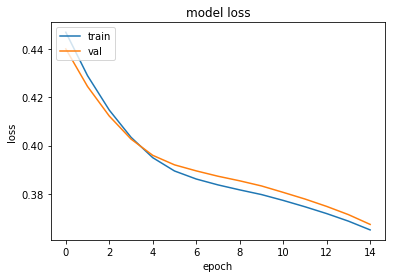

In [75]:
loss_type = 'binary'
model_1v5, history_1v5 = train_model('1v5', get_unet1v5, 8, 15, loss_type)

plot_history(history_1v5, loss_type)

In [76]:
pred_1v5 = predict(model_1v5, x_test_20)

20/20 [==============================] - 0s


(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.432, 'usage:', 0)
('min and max predicted values:', 0.077736318, 0.42960328)


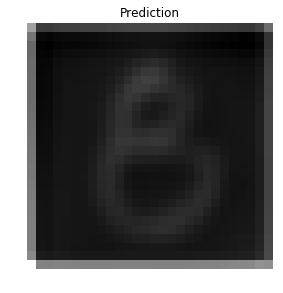

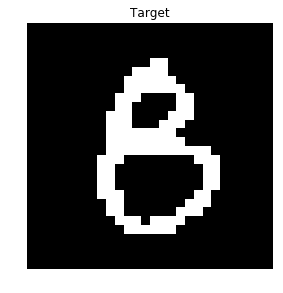

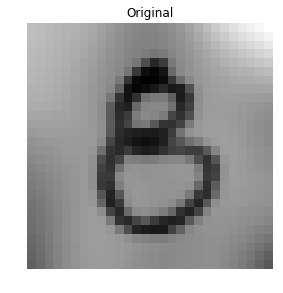

In [77]:
sample = 0
plot_preds(pred_1v5, x_test_20, sample, thresh, 0)

In [22]:
def get_unet1v5_2(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv3 = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(conv2)
    conv3 = BatchNormalization(axis=-1)(conv3)
    conv4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv3)
    
    model = Model(inputs=[inputs], outputs=[conv4])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 5s - loss: 0.6608 - acc: 0.6563 - val_loss: 0.5946 - val_acc: 0.8721
Epoch 2/15
640/640 [==============================] - 5s - loss: 0.6272 - acc: 0.7889 - val_loss: 0.6119 - val_acc: 0.8729
Epoch 3/15
640/640 [==============================] - 5s - loss: 0.5915 - acc: 0.8249 - val_loss: 0.6110 - val_acc: 0.8733
Epoch 4/15
640/640 [==============================] - 5s - loss: 0.5557 - acc: 0.8344 - val_loss: 0.5920 - val_acc: 0.8810
Epoch 5/15
640/640 [==============================] - 5s - loss: 0.5180 - acc: 0.8434 - val_loss: 0.5409 - val_acc: 0.9157
Epoch 6/15
640/640 [==============================] - 5s - loss: 0.4760 - acc: 0.8491 - val_loss: 0.4831 - val_acc: 0.9527
Epoch 7/15
640/640 [==============================] - 5s - loss: 0.4418 - acc: 0.8623 - val_loss: 0.4193 - val_acc: 0.9621
Epoch 8/15
640/640 [==============================] - 5s - loss: 0.4110 - acc: 0.8765 - val_l

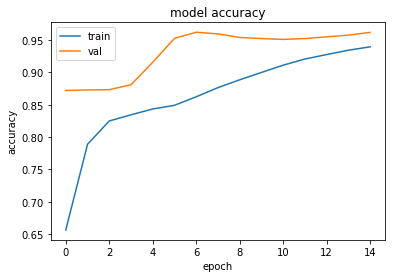

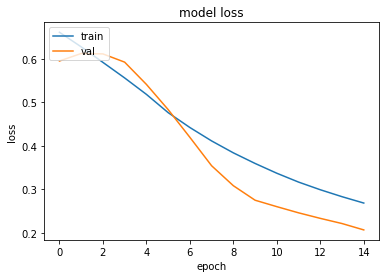

In [23]:
from keras.layers.normalization import BatchNormalization
loss_type = 'binary'
model_1v5_2, history_1v5_2 = train_model('1v5_2', get_unet1v5_2, 8, 15, loss_type)

plot_history(history_1v5_2, loss_type)

In [25]:
pred_1v5_2 = predict(model_1v5_2, x_test_20)

20/20 [==============================] - 0s


In [28]:
def get_unet1v5_3(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv3 = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(conv2)
    conv3 = BatchNormalization(axis=-1)(conv3)
    conv4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv3)
    conv4 = BatchNormalization(axis=-1)(conv3)
    conv4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv4)
    
    model = Model(inputs=[inputs], outputs=[conv4])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 7s - loss: 0.6881 - acc: 0.5784 - val_loss: 0.5432 - val_acc: 0.8376
Epoch 2/15
640/640 [==============================] - 6s - loss: 0.5658 - acc: 0.7667 - val_loss: 0.5365 - val_acc: 0.8376
Epoch 3/15
640/640 [==============================] - 7s - loss: 0.4851 - acc: 0.8279 - val_loss: 0.5281 - val_acc: 0.8376
Epoch 4/15
640/640 [==============================] - 7s - loss: 0.4232 - acc: 0.8746 - val_loss: 0.5134 - val_acc: 0.8357
Epoch 5/15
640/640 [==============================] - 7s - loss: 0.3765 - acc: 0.9030 - val_loss: 0.4836 - val_acc: 0.8918
Epoch 6/15
640/640 [==============================] - 6s - loss: 0.3404 - acc: 0.9167 - val_loss: 0.4405 - val_acc: 0.9421
Epoch 7/15
640/640 [==============================] - 7s - loss: 0.3107 - acc: 0.9272 - val_loss: 0.3889 - val_acc: 0.9605
Epoch 8/15
640/640 [==============================] - 7s - loss: 0.2848 - acc: 0.9359 - val_l

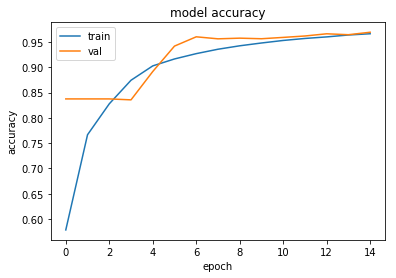

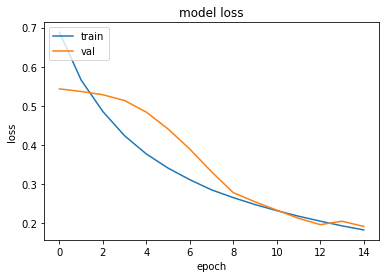

20/20 [==============================] - 0s


In [29]:
from keras.layers.normalization import BatchNormalization
loss_type = 'binary'
model_1v5_3, history_1v5_3 = train_model('1v5_3', get_unet1v5_3, 8, 15, loss_type)

plot_history(history_1v5_3, loss_type)

pred_1v5_3 = predict(model_1v5_3, x_test_20)

In [51]:
sample = 0

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.00087732822, 0.9979834)


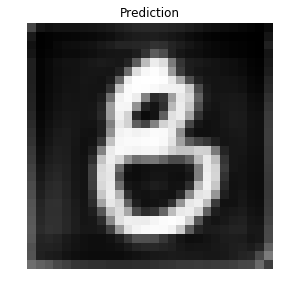

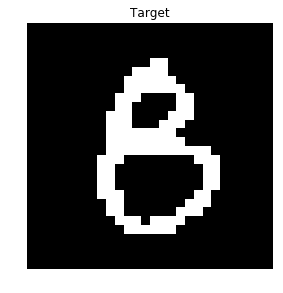

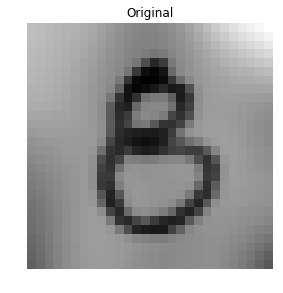

In [52]:
plot_preds(pred_1v5_2, x_test_20, sample, thresh, 0)

In [1]:
smaple = 2
plot_preds(pred_1v5_3, x_test_20, sample, thresh, 0)

NameError: name 'plot_preds' is not defined

## unet_1v6 - extra conv layer from 1v4

In [1]:
def get_unet1v6(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv3)
    
    model = Model(inputs=[inputs], outputs=[conv4])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 11s - loss: 0.6449 - acc: 0.8740 - val_loss: 0.6265 - val_acc: 0.8721
Epoch 2/15
640/640 [==============================] - 12s - loss: 0.6036 - acc: 0.8748 - val_loss: 0.5808 - val_acc: 0.8731
Epoch 3/15
640/640 [==============================] - 10s - loss: 0.5528 - acc: 0.8759 - val_loss: 0.5240 - val_acc: 0.8733
Epoch 4/15
640/640 [==============================] - 11s - loss: 0.4875 - acc: 0.8760 - val_loss: 0.4561 - val_acc: 0.8733
Epoch 5/15
640/640 [==============================] - 10s - loss: 0.4296 - acc: 0.8760 - val_loss: 0.4124 - val_acc: 0.8733
Epoch 6/15
640/640 [==============================] - 11s - loss: 0.3970 - acc: 0.8760 - val_loss: 0.3904 - val_acc: 0.8733
Epoch 7/15
640/640 [==============================] - 11s - loss: 0.3817 - acc: 0.8760 - val_loss: 0.3812 - val_acc: 0.8733
Epoch 8/15
640/640 [==============================] - 12s - loss: 0.3748 - acc: 0.8760

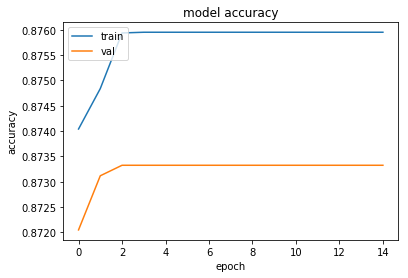

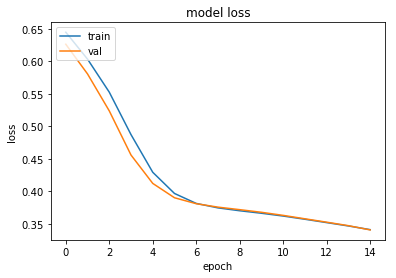

In [6]:
loss_type = 'binary'
model_1v6, history_1v6 = train_model('1v6', get_unet1v6, 8, 15, loss_type)

plot_history(history_1v6, loss_type)

In [8]:
pred_1v6 = predict(model_1v6, x_test_20)

20/20 [==============================] - 0s


(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.034029782, 0.37037188)


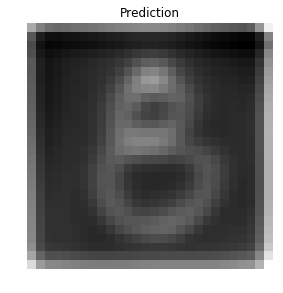

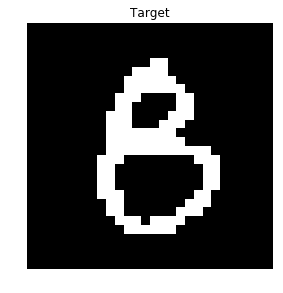

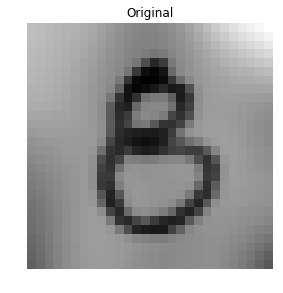

In [9]:
sample = 0
plot_preds(pred_1v6, x_test_20, sample, thresh, 0)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.13, 'usage:', 1)
('min and max predicted values:', 0.034029782, 0.37037188)


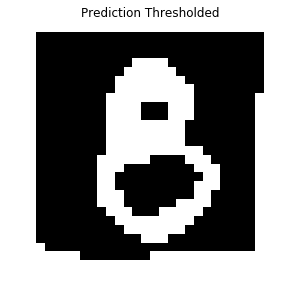

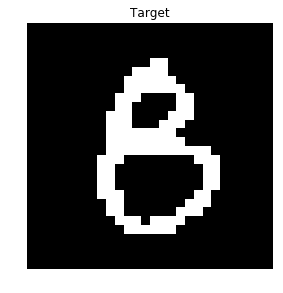

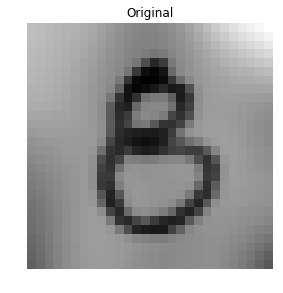

In [20]:
thresh = 0.13
sample = 0
plot_preds(pred_1v6, x_test_20, sample, thresh, 1)

## unet_1v7 - similar to or same as detection network

In [35]:
def get_unet1v7(inputs, lossind):

   
    inputs = Input((w, h, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)
    
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
   
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv5)
    
    model = Model(inputs=[inputs], outputs=[conv6])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 6s - loss: 0.6893 - acc: 0.8341 - val_loss: 0.6846 - val_acc: 0.8714
Epoch 2/15
640/640 [==============================] - 6s - loss: 0.6758 - acc: 0.8746 - val_loss: 0.6606 - val_acc: 0.8721
Epoch 3/15
640/640 [==============================] - 6s - loss: 0.5921 - acc: 0.8747 - val_loss: 0.5068 - val_acc: 0.8721
Epoch 4/15
640/640 [==============================] - 6s - loss: 0.4880 - acc: 0.8747 - val_loss: 0.4782 - val_acc: 0.8721
Epoch 5/15
640/640 [==============================] - 6s - loss: 0.4570 - acc: 0.8747 - val_loss: 0.4420 - val_acc: 0.8721
Epoch 6/15
640/640 [==============================] - 6s - loss: 0.4108 - acc: 0.8747 - val_loss: 0.3841 - val_acc: 0.8721
Epoch 7/15
640/640 [==============================] - 6s - loss: 0.3449 - acc: 0.8747 - val_loss: 0.3178 - val_acc: 0.8721
Epoch 8/15
640/640 [==============================] - 6s - loss: 0.2891 - acc: 0.8747 - val_l

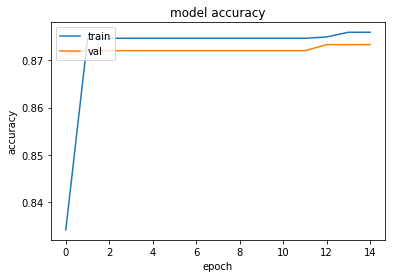

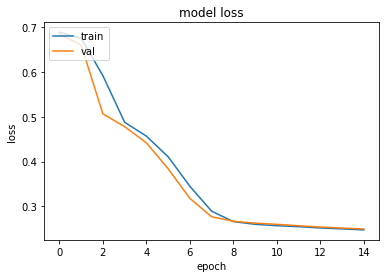

20/20 [==============================] - 0s


In [36]:
loss_type = 'binary'
model_1v7, history_1v7 = train_model('1v7', get_unet1v7, 8, 15, loss_type)

plot_history(history_1v7, loss_type)

pred_1v7 = predict(model_1v7, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.402, 'usage:', 0)
('min and max predicted values:', 1.9528456e-05, 0.48992753)


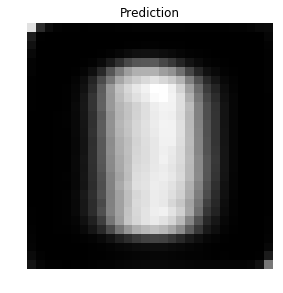

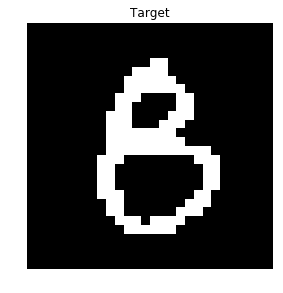

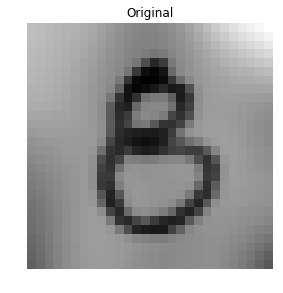

In [38]:
sample = 0
plot_preds(pred_1v7, x_test_20, sample, thresh, 0)

## unet - Cher's loss

Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 1s - loss: 437.0849 - weighted_crossentropy_coeff: -437.0849 - val_loss: 442.4690 - val_weighted_crossentropy_coeff: -442.4690
Epoch 2/30
640/640 [==============================] - 1s - loss: 429.5553 - weighted_crossentropy_coeff: -429.5553 - val_loss: 434.8491 - val_weighted_crossentropy_coeff: -434.8491
Epoch 3/30
640/640 [==============================] - 1s - loss: 422.0186 - weighted_crossentropy_coeff: -422.0186 - val_loss: 427.2609 - val_weighted_crossentropy_coeff: -427.2609
Epoch 4/30
640/640 [==============================] - 1s - loss: 414.5102 - weighted_crossentropy_coeff: -414.5102 - val_loss: 419.6366 - val_weighted_crossentropy_coeff: -419.6366
Epoch 5/30
640/640 [==============================] - 1s - loss: 406.9819 - weighted_crossentropy_coeff: -406.9819 - val_loss: 412.0281 - val_weighted_crossentropy_coeff: -412.0281
Epoch 6/30
640/640 [=============================

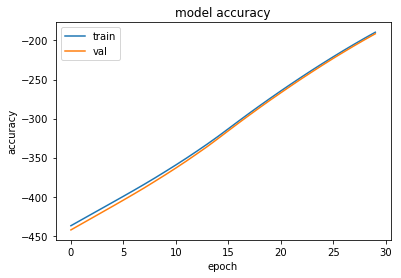

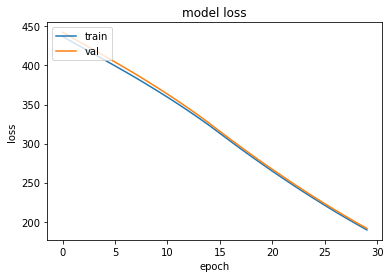

In [39]:
loss_type = 'weighted'
model_1v3o2, history_1v3o2 = train_model('1v3o2', get_unet1v3, 8, 30, loss_type)

plot_history(history_1v3o2, loss_type)

In [40]:
pred_1v3o2 = predict(model_1v3o2, x_test_20)

20/20 [==============================] - 0s


(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.1309572160243988, 'usage:', 0)
('min and max predicted values:', 0.58651572, 0.84843016)


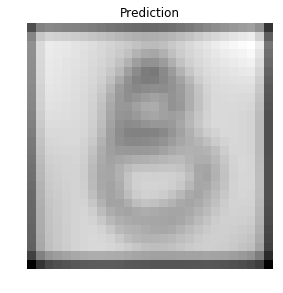

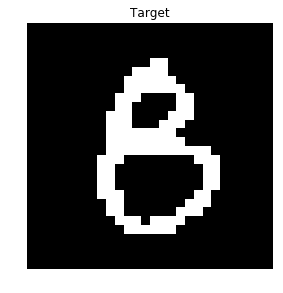

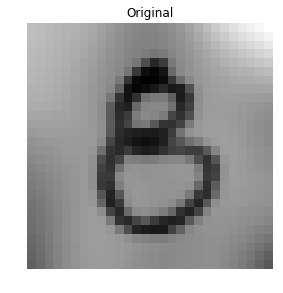

In [41]:
plot_preds(pred_1v3o2, x_test_20, sample, thresh, 0)

Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 0s - loss: 434.3372 - weighted_crossentropy_coeff: -434.3372 - val_loss: 441.3055 - val_weighted_crossentropy_coeff: -441.3055
Epoch 2/30
640/640 [==============================] - 0s - loss: 430.1998 - weighted_crossentropy_coeff: -430.1998 - val_loss: 437.0811 - val_weighted_crossentropy_coeff: -437.0811
Epoch 3/30
640/640 [==============================] - 0s - loss: 425.9798 - weighted_crossentropy_coeff: -425.9798 - val_loss: 432.7509 - val_weighted_crossentropy_coeff: -432.7509
Epoch 4/30
640/640 [==============================] - 0s - loss: 421.6007 - weighted_crossentropy_coeff: -421.6007 - val_loss: 428.2257 - val_weighted_crossentropy_coeff: -428.2257
Epoch 5/30
640/640 [==============================] - 0s - loss: 417.0267 - weighted_crossentropy_coeff: -417.0267 - val_loss: 423.4767 - val_weighted_crossentropy_coeff: -423.4767
Epoch 6/30
640/640 [=============================

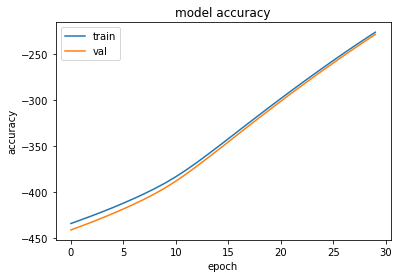

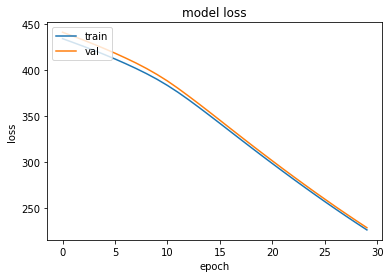

20/20 [==============================] - 0s


In [22]:
loss_type = 'weighted'
model_1v3o3, history_1v3o3 = train_model('1v3o3', get_unet1v3, 8, 30, loss_type)

plot_history(history_1v3o3, loss_type)
pred_1v3o3 = predict(model_1v3o3, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.20037191, 0.41938865)


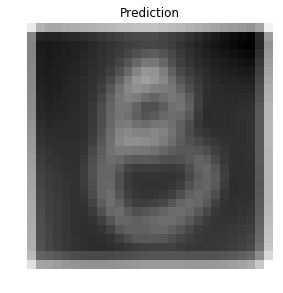

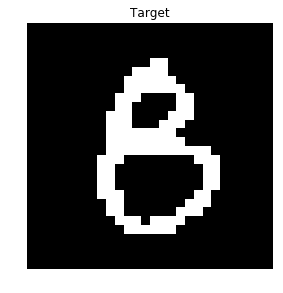

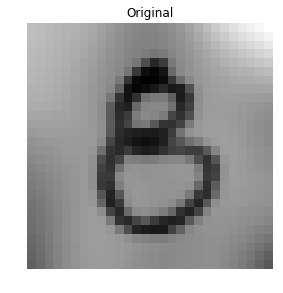

In [41]:
sample = 0
plot_preds(pred_1v3o3, x_test_20, sample, thresh, 0)

Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 0s - loss: 1692.5923 - weighted_crossentropy_coeff: -1692.5923 - val_loss: 1675.2336 - val_weighted_crossentropy_coeff: -1675.2336
Epoch 2/30
640/640 [==============================] - 0s - loss: 1666.7830 - weighted_crossentropy_coeff: -1666.7830 - val_loss: 1649.8597 - val_weighted_crossentropy_coeff: -1649.8597
Epoch 3/30
640/640 [==============================] - 0s - loss: 1641.3382 - weighted_crossentropy_coeff: -1641.3382 - val_loss: 1624.5579 - val_weighted_crossentropy_coeff: -1624.5579
Epoch 4/30
640/640 [==============================] - 0s - loss: 1615.7389 - weighted_crossentropy_coeff: -1615.7389 - val_loss: 1598.9186 - val_weighted_crossentropy_coeff: -1598.9186
Epoch 5/30
640/640 [==============================] - 0s - loss: 1589.7418 - weighted_crossentropy_coeff: -1589.7418 - val_loss: 1572.8456 - val_weighted_crossentropy_coeff: -1572.8456
Epoch 6/30
640/640 [=========

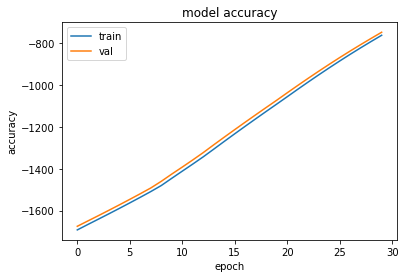

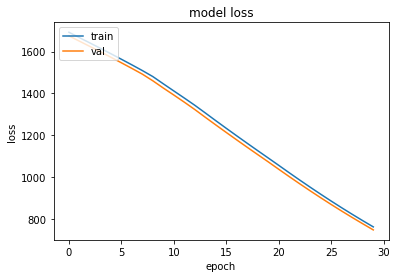

20/20 [==============================] - 0s


In [49]:
loss_type = 'weighted'
model_1v3o4, history_1v3o4 = train_model('1v3o3', get_unet1v3, 8, 30, loss_type)

plot_history(history_1v3o4, loss_type)
pred_1v3o4 = predict(model_1v3o4, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.59270775, 0.83854294)


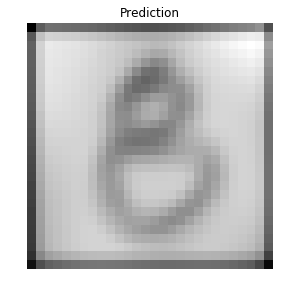

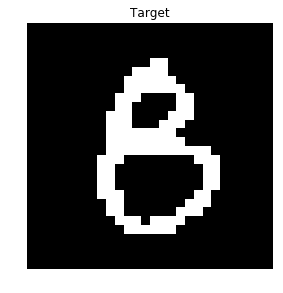

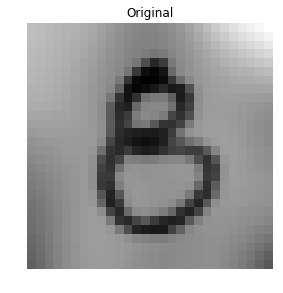

In [50]:
sample = 0
plot_preds(pred_1v3o4, x_test_20, sample, thresh, 0)

## unet_1v8 - 1st group same as detection for common trunk

In [15]:
def get_unet1v8(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    #conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    
    conv3 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv1)
    
    model = Model(inputs=[inputs], outputs=[conv3])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 1s - loss: 0.7196 - acc: 0.1271 - val_loss: 0.7147 - val_acc: 0.1316
Epoch 2/15
640/640 [==============================] - 1s - loss: 0.7111 - acc: 0.1325 - val_loss: 0.7071 - val_acc: 0.1440
Epoch 3/15
640/640 [==============================] - 1s - loss: 0.7039 - acc: 0.1917 - val_loss: 0.7003 - val_acc: 0.2478
Epoch 4/15
640/640 [==============================] - 1s - loss: 0.6973 - acc: 0.2952 - val_loss: 0.6941 - val_acc: 0.3593
Epoch 5/15
640/640 [==============================] - 1s - loss: 0.6913 - acc: 0.5685 - val_loss: 0.6887 - val_acc: 0.7561
Epoch 6/15
640/640 [==============================] - 1s - loss: 0.6867 - acc: 0.7876 - val_loss: 0.6846 - val_acc: 0.8108
Epoch 7/15
640/640 [==============================] - 1s - loss: 0.6827 - acc: 0.8475 - val_loss: 0.6808 - val_acc: 0.8659
Epoch 8/15
640/640 [==============================] - 1s - loss: 0.6769 - acc: 0.8746 - val_l

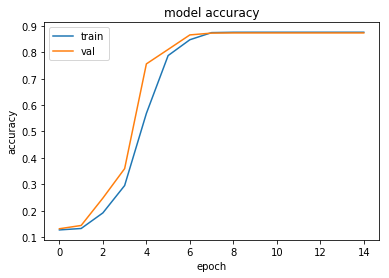

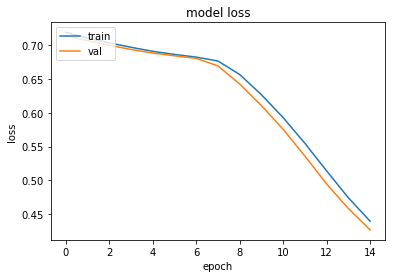

20/20 [==============================] - 0s


In [7]:
loss_type = 'binary'
model_1v8, history_1v8 = train_model('1v7', get_unet1v8, 8, 15, loss_type)

plot_history(history_1v8, loss_type)

pred_1v8 = predict(model_1v8, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.1895285, 0.4755497)


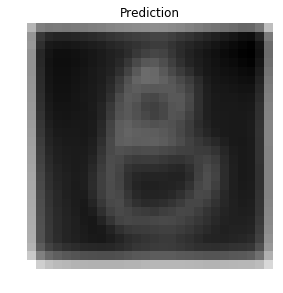

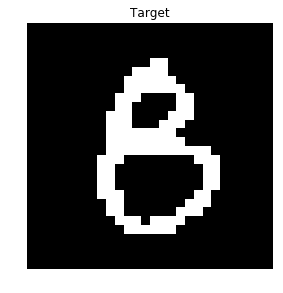

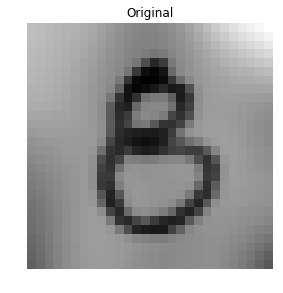

In [9]:
plot_preds(pred_1v8, x_test_20, sample, thresh, 0)

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 1s - loss: 421.5772 - weighted_crossentropy_coeff: -421.5772 - val_loss: 425.0461 - val_weighted_crossentropy_coeff: -425.0461
Epoch 2/15
640/640 [==============================] - 1s - loss: 411.0552 - weighted_crossentropy_coeff: -411.0552 - val_loss: 414.5173 - val_weighted_crossentropy_coeff: -414.5173
Epoch 3/15
640/640 [==============================] - 1s - loss: 400.1801 - weighted_crossentropy_coeff: -400.1801 - val_loss: 402.4608 - val_weighted_crossentropy_coeff: -402.4608
Epoch 4/15
640/640 [==============================] - 1s - loss: 386.6006 - weighted_crossentropy_coeff: -386.6006 - val_loss: 386.8940 - val_weighted_crossentropy_coeff: -386.8940
Epoch 5/15
640/640 [==============================] - 1s - loss: 369.6162 - weighted_crossentropy_coeff: -369.6162 - val_loss: 367.7258 - val_weighted_crossentropy_coeff: -367.7258
Epoch 6/15
640/640 [=============================

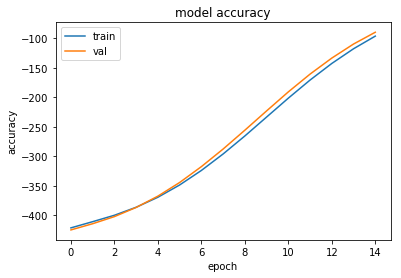

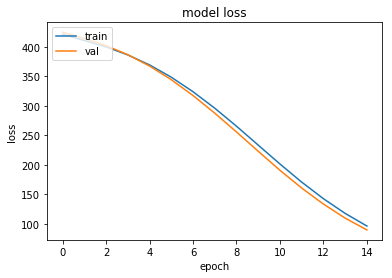

20/20 [==============================] - 0s


In [10]:
loss_type = 'weighted'
model_1v8_2, history_1v8_2 = train_model('1v8_2', get_unet1v8, 8, 15, loss_type)

plot_history(history_1v8_2, loss_type)

pred_1v8_2 = predict(model_1v8_2, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.59487134, 0.94267845)


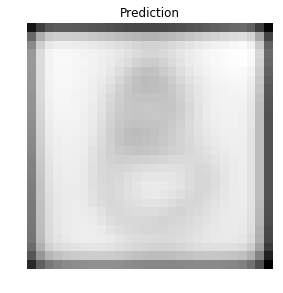

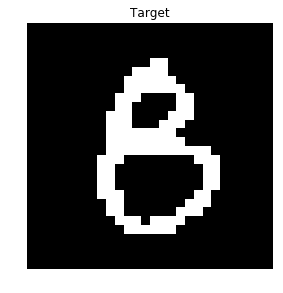

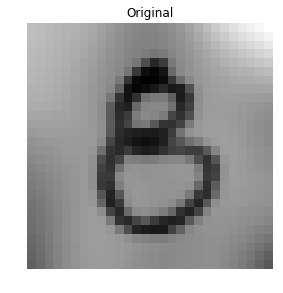

In [11]:
plot_preds(pred_1v8_2, x_test_20, sample, thresh, 0)

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 1s - loss: 0.8154 - acc: 0.1240 - val_loss: 0.8059 - val_acc: 0.1267
Epoch 2/15
640/640 [==============================] - 0s - loss: 0.7993 - acc: 0.1240 - val_loss: 0.7906 - val_acc: 0.1267
Epoch 3/15
640/640 [==============================] - 1s - loss: 0.7845 - acc: 0.1240 - val_loss: 0.7765 - val_acc: 0.1267
Epoch 4/15
640/640 [==============================] - 1s - loss: 0.7699 - acc: 0.1240 - val_loss: 0.7606 - val_acc: 0.1267
Epoch 5/15
640/640 [==============================] - 1s - loss: 0.7531 - acc: 0.1243 - val_loss: 0.7445 - val_acc: 0.1274
Epoch 6/15
640/640 [==============================] - 1s - loss: 0.7377 - acc: 0.1262 - val_loss: 0.7300 - val_acc: 0.1323
Epoch 7/15
640/640 [==============================] - 1s - loss: 0.7236 - acc: 0.1499 - val_loss: 0.7166 - val_acc: 0.1613
Epoch 8/15
640/640 [==============================] - 1s - loss: 0.7103 - acc: 0.1818 - val_l

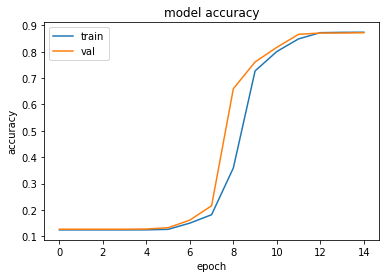

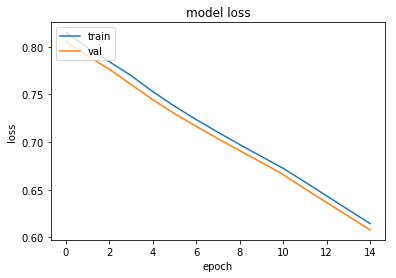

20/20 [==============================] - 0s


In [13]:
loss_type = 'binary'
model_1v8, history_1v8 = train_model('1v8', get_unet1v8, 8, 15, loss_type)

plot_history(history_1v8, loss_type)

pred_1v8 = predict(model_1v8, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.39846632, 0.50496161)


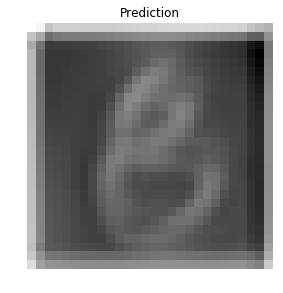

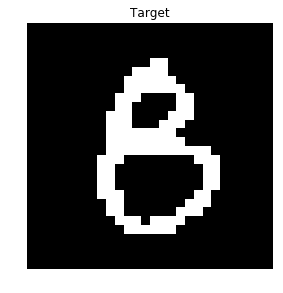

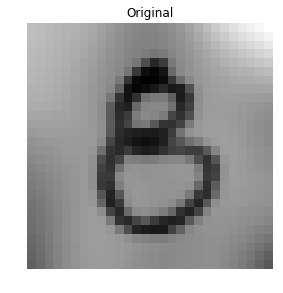

In [14]:
plot_preds(pred_1v8, x_test_20, sample, thresh, 0)

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 0s - loss: 0.7868 - acc: 0.1240 - val_loss: 0.7767 - val_acc: 0.1267
Epoch 2/15
640/640 [==============================] - 0s - loss: 0.7693 - acc: 0.1246 - val_loss: 0.7604 - val_acc: 0.1279
Epoch 3/15
640/640 [==============================] - 0s - loss: 0.7537 - acc: 0.1253 - val_loss: 0.7459 - val_acc: 0.1281
Epoch 4/15
640/640 [==============================] - 0s - loss: 0.7405 - acc: 0.1394 - val_loss: 0.7341 - val_acc: 0.1582
Epoch 5/15
640/640 [==============================] - 0s - loss: 0.7291 - acc: 0.1561 - val_loss: 0.7232 - val_acc: 0.1600
Epoch 6/15
640/640 [==============================] - 0s - loss: 0.7184 - acc: 0.1621 - val_loss: 0.7127 - val_acc: 0.1769
Epoch 7/15
640/640 [==============================] - 0s - loss: 0.7079 - acc: 0.2114 - val_loss: 0.7024 - val_acc: 0.2626
Epoch 8/15
640/640 [==============================] - 0s - loss: 0.6973 - acc: 0.3779 - val_l

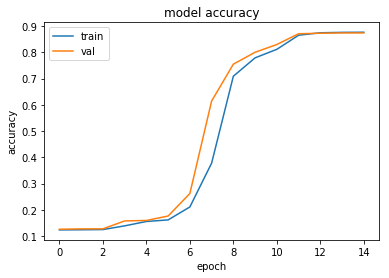

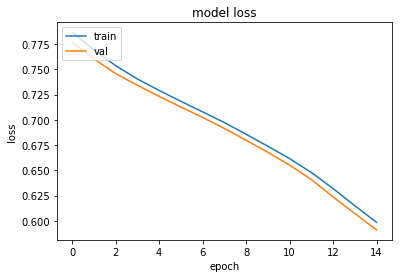

20/20 [==============================] - 0s


In [16]:
loss_type = 'binary'
model_1v8, history_1v8 = train_model('1v8', get_unet1v8, 8, 15, loss_type)

plot_history(history_1v8, loss_type)

pred_1v8 = predict(model_1v8, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.37644297, 0.49342832)


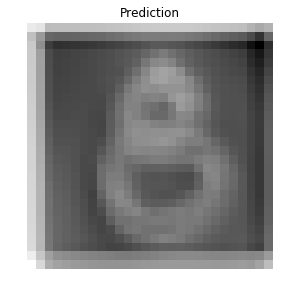

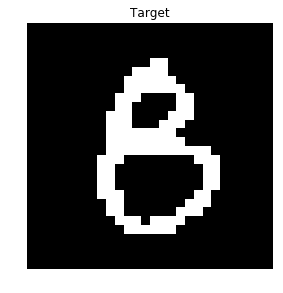

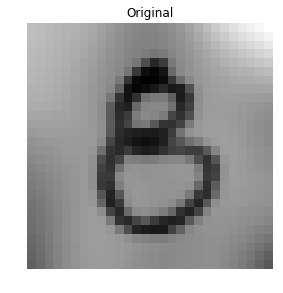

In [17]:
plot_preds(pred_1v8, x_test_20, sample, thresh, 0)

# Older - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 

## unet_3

In [4]:
def get_unet3_128(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)
    
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
   
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv5)
    
    model = Model(inputs=[inputs], outputs=[conv6])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model


## unet_2

In [5]:
def get_unet2(inputs, lossind):
    #model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
    
    inputs = Input((w,h,1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)

    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv5)


    #training
    model = Model(inputs=inputs, outputs=conv6)
    
    #model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])#/, sample_weight_mode="temporal")
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

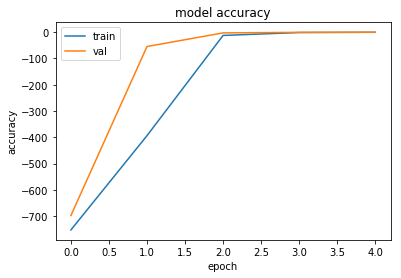

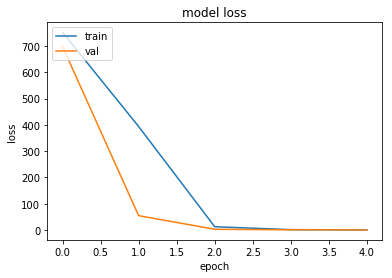

In [39]:
plot_history(history, loss_type)
    